# ResNet50 - CNN + Masks

This notebook uses the ResNet50 model architecture in combination with the unet predicted masks.

In [20]:
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from pathlib import Path
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, Conv2D, MaxPool2D, Activation, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [21]:
# Config
IMG_SIZE = 256
BATCH_SIZE=32
train_path = 'data/chest-x-ray/train/'
test_path = 'data/chest-x-ray/test/'
val_path = 'data/chest-x-ray/val/'

train_mask_path = 'data/chest-x-ray/masks/train/'

## 1 Data preparation

In [22]:
def load_images_from_folder(img_folder, masks_folder):
    tmp_df = pd.DataFrame(columns = ['img', 'label', 'mask'])
    
    # IMGs
    for label_folder in os.listdir(img_folder):
        # print(label_folder)
        for filename in os.listdir(img_folder + '/' + label_folder):
            img_path = str(img_folder)+str(label_folder)+'/'+str(filename)
            # normal file ending is jpEg...
            filename_wo_ending = filename.split('.jpeg')[0]
            mask_path = str(masks_folder)+str(label_folder)+'/'+str(filename_wo_ending) + '_predmask.jpg'

            if img_path is not None:
                tmp_df = tmp_df.append({'img': img_path, 'label': label_folder, 'mask': mask_path}, ignore_index=True)

    return tmp_df

In [23]:
df_train = load_images_from_folder(train_path, train_mask_path)
# df_val = load_images_from_folder(val_path)
# df_test = load_images_from_folder(test_path)

In [24]:
df_train

,img,label,mask
0,data/chest-x-ray/train/NORMAL/IM-0115-0001.jpeg,NORMAL,data/chest-x-ray/masks/train/NORMAL/IM-0115-00...
1,data/chest-x-ray/train/NORMAL/IM-0117-0001.jpeg,NORMAL,data/chest-x-ray/masks/train/NORMAL/IM-0117-00...
2,data/chest-x-ray/train/NORMAL/IM-0119-0001.jpeg,NORMAL,data/chest-x-ray/masks/train/NORMAL/IM-0119-00...
3,data/chest-x-ray/train/NORMAL/IM-0122-0001.jpeg,NORMAL,data/chest-x-ray/masks/train/NORMAL/IM-0122-00...
4,data/chest-x-ray/train/NORMAL/IM-0125-0001.jpeg,NORMAL,data/chest-x-ray/masks/train/NORMAL/IM-0125-00...
...,...,...,...
5211,data/chest-x-ray/train/PNEUMONIA/person99_viru...,PNEUMONIA,data/chest-x-ray/masks/train/PNEUMONIA/person9...
5212,data/chest-x-ray/train/PNEUMONIA/person9_bacte...,PNEUMONIA,data/chest-x-ray/masks/train/PNEUMONIA/person9...
5213,data/chest-x-ray/train/PNEUMONIA/person9_bacte...,PNEUMONIA,data/chest-x-ray/masks/train/PNEUMONIA/person9...
5214,data/chest-x-ray/train/PNEUMONIA/person9_bacte...,PNEUMONIA,data/chest-x-ray/masks/train/PNEUMONIA/person9...


In [25]:
print('=== Data: ===')
print('Train:', len(df_train))
# print('Val:', len(df_val))
# print('Test:', len(df_test))

=== Data: ===
Train: 5216


In [26]:
df_train['label'].replace(
    to_replace='NORMAL',
    value=0,
    inplace=True
)
df_train['label'].replace(
    to_replace='PNEUMONIA',
    value=1,
    inplace=True
)

In [27]:
df_train = df_train.sample(frac=1, random_state=200).reset_index(drop=True)

In [28]:
df_train

,img,label,mask
0,data/chest-x-ray/train/PNEUMONIA/person307_bac...,1,data/chest-x-ray/masks/train/PNEUMONIA/person3...
1,data/chest-x-ray/train/PNEUMONIA/person1400_ba...,1,data/chest-x-ray/masks/train/PNEUMONIA/person1...
2,data/chest-x-ray/train/PNEUMONIA/person1369_vi...,1,data/chest-x-ray/masks/train/PNEUMONIA/person1...
3,data/chest-x-ray/train/PNEUMONIA/person488_vir...,1,data/chest-x-ray/masks/train/PNEUMONIA/person4...
4,data/chest-x-ray/train/NORMAL/IM-0482-0001.jpeg,0,data/chest-x-ray/masks/train/NORMAL/IM-0482-00...
...,...,...,...
5211,data/chest-x-ray/train/NORMAL/NORMAL2-IM-0736-...,0,data/chest-x-ray/masks/train/NORMAL/NORMAL2-IM...
5212,data/chest-x-ray/train/PNEUMONIA/person1777_ba...,1,data/chest-x-ray/masks/train/PNEUMONIA/person1...
5213,data/chest-x-ray/train/NORMAL/NORMAL2-IM-0635-...,0,data/chest-x-ray/masks/train/NORMAL/NORMAL2-IM...
5214,data/chest-x-ray/train/PNEUMONIA/person718_vir...,1,data/chest-x-ray/masks/train/PNEUMONIA/person7...


In [29]:
len(df_train[df_train.label == 0])

1341

## 2 Data generator

In [30]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, x_col, y_col=None, batch_size=32, num_classes=None, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.x_col = x_col
        self.y_col = y_col
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in indexes]        
        X, y = self.__get_data(batch)
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        # Todo: Fix?
        # self.indexes = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.indices)        

    def __get_data(self, batch):
        X_img_paths = self.df['img']
        X_mask_paths = self.df['mask']
        Y = self.df['label'].iloc[batch].to_numpy()
        
        X_imgs = []
        X_masks = []

        for i in range(0, len(batch)):
            img = cv2.resize(cv2.imread(str(X_img_paths.iloc[i]), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
            mask = cv2.resize(cv2.imread(str(X_mask_paths.iloc[i]), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
            X_imgs.append(img)
            X_masks.append(mask)
       
        return np.stack((X_imgs, X_masks), axis=3), Y

In [31]:
train_generator = DataGenerator(df_train, None, None, 32, None, None)

## 3 Model training

In [32]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding = "same", input_shape=(IMG_SIZE,IMG_SIZE,2)))
model.add(Activation(activations.relu))
model.add(Conv2D(32, (3,3), padding = "same"))
model.add(Activation(activations.relu))
model.add(MaxPool2D(pool_size = (3, 3)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding = "same", input_shape=(IMG_SIZE,IMG_SIZE,2)))
model.add(Activation(activations.relu))
model.add(Conv2D(128, (2,2), padding = "same"))
model.add(Activation(activations.relu))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation(activations.relu))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation(activations.relu))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# TOOD: binary crossentropy
model.compile(optimizer = Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 32)      608       
_________________________________________________________________
activation_12 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
activation_13 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 85, 85, 64)       

In [13]:
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [early_stop]

In [33]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator),
                    epochs=10, 
                    # callbacks=callbacks_list,
                    verbose = True)

Epoch 1/10
163/163 [==============================] - 34s 209ms/step - loss: 8.8561e-08 - accuracy: 0.5623
Epoch 2/10
163/163 [==============================] - 34s 211ms/step - loss: 8.8561e-08 - accuracy: 0.5602
Epoch 3/10
163/163 [==============================] - 35s 212ms/step - loss: 8.8561e-08 - accuracy: 0.5690
Epoch 4/10
163/163 [==============================] - 34s 211ms/step - loss: 8.8561e-08 - accuracy: 0.5700
Epoch 5/10
163/163 [==============================] - 34s 211ms/step - loss: 8.8561e-08 - accuracy: 0.5742
Epoch 6/10
163/163 [==============================] - 35s 212ms/step - loss: 8.8561e-08 - accuracy: 0.5608
Epoch 7/10
163/163 [==============================] - 34s 211ms/step - loss: 8.8561e-08 - accuracy: 0.5623
Epoch 8/10
163/163 [==============================] - 34s 211ms/step - loss: 8.8561e-08 - accuracy: 0.5713
Epoch 9/10
163/163 [==============================] - 35s 212ms/step - loss: 8.8561e-08 - accuracy: 0.5692
Epoch 10/10
163/163 [================

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

KeyError: 'val_accuracy'

## 4 Model evaluation

In [51]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(test_generator)
print('test loss, test acc:', results)


# Evaluate on test data
15/15 [==============================] - 5s 352ms/step - loss: 0.2079 - accuracy: 0.9278
test loss, test acc: [0.2079380750656128, 0.9278131723403931]


In [52]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.round(predictions)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [53]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [54]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.97      0.82      0.89       168
   PNEUMONIA       0.91      0.99      0.95       303

    accuracy                           0.93       471
   macro avg       0.94      0.90      0.92       471
weighted avg       0.93      0.93      0.93       471



In [55]:
y_true = test_generator.classes
y_pred = predictions > 0.5

In [56]:
# https://www.kaggle.com/grfiv4/plot-a-confusion-matrix/data
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [57]:
y_pred = np.round(predictions)
cm = confusion_matrix(test_generator.classes, y_pred)

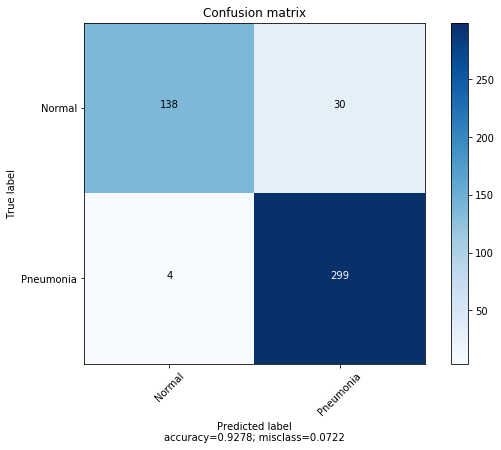

In [58]:
plot_confusion_matrix(cm, ['Normal', 'Pneumonia'], normalize=False)